In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Data Collection
1. Open a serial connection to the specified port and baud rate, and create an output file for logging data.  
2. Continuously read data from the serial port, checking for lines containing the keyword `CSI_DATA` and writing them to the file.  
3. Group every 300 samples as a "new instance," marking it in the file, and repeat until stopped by the user (Ctrl+C).  
4. Handle errors gracefully, ensuring any exceptions are displayed for troubleshooting.  

In [ ]:
import serial

def log_serial_data(port, baudrate, output_file, samples_per_instance=300):
    try:
        with serial.Serial(port, baudrate, timeout=1) as ser, open(output_file, 'wb') as file:
            print(f"Connected to {port} at {baudrate} baud.")
            print("Listening for data... Press Ctrl+C to stop.")

            sample_count = 0  # Initialize sample counter
            instance_number = 1
            while True:
                try:
                    # Read raw bytes from the serial port
                    raw_line = ser.readline()

                    # Check if the line contains the keyword `CSI_DATA`
                    if b'CSI_DATA' in raw_line:
                        # Write the raw line to the output file
                        file.write(raw_line)
                        file.flush()  # Ensure data is written immediately

                        # Increment the sample count
                        sample_count += 1

                        # After 300 samples, write "new instance" to the file and reset count
                        if sample_count >= samples_per_instance:
                            instance_message = f"new instance {instance_number}\n".encode('utf-8')  # Encode string to bytes
                            file.write(instance_message)  # Write instance info as bytes
                            file.flush()
                            print(f"new {instance_number}")  # Print to console with instance number
                            sample_count = 0  # Reset the sample count
                            instance_number += 1  # Increment the instance number
                except KeyboardInterrupt:
                    print("\nData logging stopped by user.")
                    break
    except Exception as e:
        print(f"Error: {e}")

# Configuration
PORT = "COM7"          # Adjust if using a different port
BAUDRATE = 921600
OUTPUT_FILE = "csi_data_clap_v1.3"

log_serial_data(PORT, BAUDRATE, OUTPUT_FILE)


## 1.2 Data Cleaning and Preparing the CSI Data:

1. **Initial Cleaning and Header Addition**  
   - Loaded the raw CSI data CSV file and removed unnecessary columns (e.g., those starting with "Unnamed").  
   - Added a new header row with appropriate column names to standardize the file structure.  

2. **Instance Numbering**  
   - Iterated through the data to assign an instance number to each row, marking rows containing "new instance" and grouping samples accordingly.  
   - Dropped rows with "new instance" and retained only meaningful data points.

3. **Filtering Invalid Data**  
   - Removed rows where the `data` column had invalid or incorrectly formatted entries.  
   - Filtered out rows where the length of the `data` column was not equal to 384 (expected CSI data length).  

4. **Removing Small Instances**  
   - Grouped rows by instance number and retained only instances with a minimum of 300 rows to ensure data quality.

5. **Row Counts and Validation**  
   - Verified the shape of the cleaned data and counted rows per instance to confirm data consistency.  
   - Identified and addressed instances with the least number of rows.

6. **Feature Extraction**  
   - Calculated the amplitude and phase for HT-LTF subcarriers (indices 66 to 94 and 95 to 123) for each row in the `data` column.  
   - Added new columns for HT-LTF amplitudes and phases to the dataset.

7. **Saving Processed Data**  
   - Saved the fully processed and feature-enriched data into a new CSV file for further use.

In [ ]:
import pandas as pd

# Load the CSV file
input_file = '/content/drive/MyDrive/csi_data/csi_raw_data_files/mixed_data_for_testing.csv'
df = pd.read_csv(input_file, on_bad_lines='skip')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Print the cleaned columns
print(f"Cleaned Columns: {df.columns}")
print(f"Shape of the DataFrame: {df.shape}")


In [ ]:
# File path
file_path = '/content/drive/MyDrive/csi_data/csi_raw_data_files/mixed_data_for_testing.csv'

# New header
header = """type,id,mac,rssi,rate,sig_mode,mcs,bandwidth,smoothing,not_sounding,aggregation,stbc,fec_coding,sgi,noise_floor,ampdu_cnt,channel,secondary_channel,local_timestamp,ant,sig_len,rx_state,len,first_word,data"""

# Read the existing file content
with open(file_path, 'r') as file:
    original_content = file.read()

# Prepend the new header
updated_content = header + '\n' + original_content

# Write the updated content back to the file
with open(file_path, 'w') as file:
    file.write(updated_content)

print(f"Header added successfully to {file_path}.")


In [ ]:
import pandas as pd

def preprocess_csv(input_file, output_file):
    try:
        # Read the CSV file into a DataFrame, skipping any lines with parsing issues
        #df = pd.read_csv(input_file, on_bad_lines='skip')

        # Initialize variables
        instance_number = 0
        instance_column = []  # List to store instance numbers

        # Process each row in the DataFrame
        for _, row in df.iterrows():
            if "new instance" in str(row):  # Check if "new instance" is in the 'data' column

                instance_number += 1  # Increment the instance number for each new instance
                instance_column.append(None)  # Add a placeholder for the "new instance" row
            else:
                instance_column.append(instance_number)  # Add the current instance number to the row

        # Add the 'instance' column to the DataFrame
        df['instance'] = instance_column

        # Drop rows where 'data' column contains "new instance"
        df_cleaned = df[df['data'] != 'new instance']

        # Write the cleaned DataFrame with the 'instance' column to the output CSV file
        df_cleaned.to_csv(output_file, index=False)
        print(f"Processed data saved to {output_file}.")
    except Exception as e:
        print(f"Error processing file: {e}")

# Example usage
output_file = '/content/drive/MyDrive/csi_data/circle_v2.csv'  # Output file path

preprocess_csv(input_file, output_file)


In [ ]:
import pandas as pd

# Path to the CSV file
file_path = '/content/drive/MyDrive/csi_data/circle_v2.csv'

# Read the first few rows of the CSV file
df = pd.read_csv(file_path)

# Print the first 5 rows (head) of the CSV file
print(df.head())


In [ ]:
import pandas as pd
import ast

def clean_data_column(file_path, output_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Count the initial number of rows
    initial_row_count = len(df)

    # Function to check if the data length is less than 384
    def check_data_length(data):
        try:
            # Convert string representation of list to actual list
            data_list = ast.literal_eval(data)
            # Check if the length of the list is 384
            return len(data_list) == 384
        except:
            # If conversion fails (in case of any invalid data), return False
            return False

    # Apply the check to the 'data' column and filter rows
    df_filtered = df[df['data'].apply(check_data_length)]

    # Count the number of rows deleted
    rows_deleted = initial_row_count - len(df_filtered)

    # Save the cleaned DataFrame to a new file
    df_filtered.to_csv(output_file, index=False)

    # Print the number of rows deleted
    print(f"Rows deleted: {rows_deleted}")
    print(f"Shape of cleaned data: {df_filtered.shape}")

# Example usage
input_file = '/content/drive/MyDrive/csi_data/circle_v2.csv'  # Input file
output_file = '/content/drive/MyDrive/csi_data/circle_v2_cleaned.csv'  # Output file after cleaning
clean_data_column(input_file, output_file)


In [ ]:
import pandas as pd

def remove_small_instances(input_file, output_file, min_rows=300):
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(input_file)

        # Count the number of rows for each instance
        instance_counts = df['instance'].value_counts()

        # Get the instances that have more than or equal to 'min_rows' (300)
        valid_instances = instance_counts[instance_counts == min_rows].index

        # Filter the DataFrame to only keep the rows with valid instances
        df_cleaned = df[df['instance'].isin(valid_instances)]

        # Write the cleaned DataFrame to the output CSV file
        df_cleaned.to_csv(output_file, index=False)
        print(f"Processed data saved to {output_file}.")
    except Exception as e:
        print(f"Error processing file: {e}")

# Example usage
input_file = '/content/drive/MyDrive/csi_data/circle_v2_cleaned.csv'  # Input file path
output_file = '/content/drive/MyDrive/csi_data/circle_v2_with_valid_instances.csv'  # Output file path

remove_small_instances(input_file, output_file)


In [ ]:
import pandas as pd

def print_file_shape(file_path):
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Print the shape of the DataFrame (number of rows and columns)
        print(f"Shape of {file_path}: {df.shape}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Example usage for both files
input_file = '/content/drive/MyDrive/csi_data/circle_v2_cleaned.csv'  # Original file
output_file = '/content/drive/MyDrive/csi_data/circle_v2_with_valid_instances.csv'  # Cleaned file

print_file_shape(input_file)  # Print shape of the original file
print_file_shape(output_file)  # Print shape of the cleaned file


In [ ]:
import pandas as pd

def count_rows_per_instance(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Group by the 'instance' column and count the number of rows per instance
    instance_counts = df.groupby('instance').size()

    # Find the instance with the least rows
    min_instance = instance_counts.idxmin()  # The instance with the least rows
    min_instance_count = instance_counts.min()  # The number of rows for the instance with the least rows

    # Print out the instance counts and the one with the least rows
    print("Row count per instance:")
    print(instance_counts)
    print(f"\nInstance with the least rows: {min_instance} (Rows: {min_instance_count})")

    return instance_counts, min_instance, min_instance_count

# Example usage
input_file = '/content/drive/MyDrive/csi_data/circle_v2_with_valid_instances.csv'  # Input cleaned file
count_rows_per_instance(input_file)


In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
input_file = '/content/drive/MyDrive/csi_data/circle_v2_with_valid_instances.csv'  # Input cleaned file
csi_data = pd.read_csv(input_file)

# Define the HT-LTF subcarrier indices (66 to 94 and 95 to 123)
htltf_subcarrier_indices = list(range(66, 95)) + list(range(95, 124))

# Function to calculate accurate amplitude and phase for HT-LTF subcarriers
def calculate_htltf_amplitude_and_phase(row):
    # Ensure 'data' column contains a valid string representation of a list
    try:
        raw_csi_data = eval(row['data'])  # Convert the string representation of list into an actual list
    except (SyntaxError, NameError, TypeError):
        # Handle invalid or missing data by skipping or setting default values
        raw_csi_data = []

    htltf_amplitudes = []
    htltf_phases = []

    # Iterate through HT-LTF subcarriers and calculate their amplitude and phase
    for i in htltf_subcarrier_indices:
        if i < len(raw_csi_data):  # Ensure the subcarrier index is valid
            # Assuming the value is stored as a complex number (real, imaginary)
            real_part = np.real(raw_csi_data[i])
            imaginary_part = np.imag(raw_csi_data[i])

            # Calculate the amplitude (magnitude)
            amplitude = np.sqrt(real_part**2 + imaginary_part**2)

            # Calculate the phase (angle in radians)
            phase = np.angle(raw_csi_data[i])

            htltf_amplitudes.append(amplitude)
            htltf_phases.append(phase)

    return pd.Series([htltf_amplitudes, htltf_phases])

# Apply the function to each row and add two new columns: amplitude and phase for HT-LTF subcarriers
csi_data[['htltf_amplitude', 'htltf_phase']] = csi_data.apply(calculate_htltf_amplitude_and_phase, axis=1)

# Display the updated dataframe with the new columns
print(csi_data.head())  # Display the first few rows of the dataframe

# Optionally, save the updated dataframe to a new CSV file
csi_data.to_csv('/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/Mixed_test_Final_convert_v1.3_v1.1.csv', index=False)


## 2.1 Preprocessing and Label Mapping of Data for CNN Input


1. **Define File Paths and Labels**:  
   - Specify the paths to the raw CSI data files.  
   - Create a mapping between class names (`circle`, `sitting_still`, `swipe`, `clap`) and numerical labels.

2. **Load and Clean Data**:
   - Read the CSV files containing CSI data using `pandas`.  
   - Remove rows with missing values in the `htltf_amplitude` column using `dropna()`.  
   - Convert the `htltf_amplitude` column to string format for processing.

3. **Preprocess Data**:
   - Extract the amplitude values from the `htltf_amplitude` column, which are stored as comma-separated strings in square brackets.  
   - Parse these strings into numerical arrays and append them to a list.  
   - Convert the list into a NumPy array for further processing.

4. **Normalize Data**:
   - Scale the extracted amplitude values to the range `[0, 1]` by calculating the minimum and maximum values across the dataset and applying normalization.

5. **Reshape Data for CNN**:
   - Divide the normalized data into chunks of fixed size (`chunk_size = 300`) for time steps.  
   - Reshape the data into a format suitable for CNNs (`num_samples, num_subcarriers, chunk_size, 1`), where:
     - `num_samples`: Number of samples obtained by dividing the data into chunks.
     - `num_subcarriers`: Fixed number of subcarriers (58 in this case).  
     - `chunk_size`: Time steps per sample.  
     - `1`: Represents a single channel for the CNN.

6. **Label Assignment**:
   - Create numerical labels for each dataset based on the `label_mapping`.  
   - Generate an array of labels with a fixed value corresponding to the class of the dataset.

7. **Combine Data and Labels**:
   - Concatenate all reshaped data arrays across different classes into one dataset (`cnn_input_data`).  
   - Similarly, concatenate all label arrays into one (`labels`).

8. **One-Hot Encode Labels**:
   - Convert numerical labels to one-hot encoded format using `to_categorical()` to make them compatible with classification tasks in CNNs.

9. **Shuffle the Dataset**:
   - Randomize the order of samples and their corresponding labels using `shuffle()` to avoid any bias during training.

10. **Verify Final Dataset**:
    - Print the shape of the prepared dataset (`cnn_input_data`) and labels to confirm correctness.  
    - Display a sample from the data to ensure the reshaping, normalization, and labeling are accurate.

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# File paths for the raw CSI data
file_paths = {
    "circle": r"/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/circle_v2_STILL_with_htltf_amplitude_phase_FINAL.csv",
    "sitting_still": r"/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/sitting_still_v2_with_htltf_amplitude_phase_FINAL.csv",
    "swipe": r"/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/swipe_v1_with_htltf_amplitude_phase_FINAL.csv",
    "clap": r"/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/clap_v1_with_htltf_amplitude_phase_FINAL.csv"
}

# Label mapping
label_mapping = {
    "circle": 0,
    "sitting_still": 1,
    "swipe": 2,
    "clap": 3
}

def load_and_clean_data(file_path):
    """
    Load and clean the CSI data from a CSV file.
    """
    raw_data = pd.read_csv(file_path)
    cleaned_data = raw_data.dropna(subset=['htltf_amplitude'])
    cleaned_data['htltf_amplitude'] = cleaned_data['htltf_amplitude'].astype(str)
    cleaned_data.reset_index(drop=True, inplace=True)
    return cleaned_data

def preprocess_csi_data(cleaned_data):
    """
    Preprocess cleaned CSI data to extract amplitude from 'htltf_amplitude' column.
    """
    amplitude_data = cleaned_data['htltf_amplitude']
    csi_amplitude = []

    for row in amplitude_data:
        try:
            amplitude_values = list(map(float, row.strip("[]").split(',')))
            csi_amplitude.append(amplitude_values)
        except Exception as e:
            print(f"Error processing row: {row}, Error: {e}")

    return np.array(csi_amplitude)

def normalize_csi_data(csi_data):
    """
    Normalize CSI data to range [0, 1] for training.
    """
    min_val = np.min(csi_data)
    max_val = np.max(csi_data)
    return (csi_data - min_val) / (max_val - min_val)

def reshape_for_cnn(normalized_data, num_subcarriers=58, chunk_size=300):
    """
    Reshape normalized CSI data for CNN input.
    """
    num_samples = normalized_data.shape[0] // chunk_size
    return normalized_data[:num_samples * chunk_size].reshape(num_samples, num_subcarriers, chunk_size, 1)

# Initialize lists to hold data and labels
all_data = []
all_labels = []

# Process each file and assign labels
for label_name, file_path in file_paths.items():
    print(f"Processing file: {label_name}")

    # Load and clean the data
    cleaned_data = load_and_clean_data(file_path)

    # Preprocess the data
    processed_data = preprocess_csi_data(cleaned_data)

    # Normalize the data
    normalized_data = normalize_csi_data(processed_data)

    # Reshape the data for CNN
    reshaped_data = reshape_for_cnn(normalized_data)

    # Append to the main data list
    all_data.append(reshaped_data)

    # Create labels for the data
    num_samples = reshaped_data.shape[0]
    labels = np.full(num_samples, label_mapping[label_name])
    all_labels.append(labels)

# Combine all data and labels
cnn_input_data = np.concatenate(all_data, axis=0)
labels = np.concatenate(all_labels, axis=0)

# Convert labels to categorical format (one-hot encoding)
labels = to_categorical(labels, num_classes=len(label_mapping))

# Shuffle the data and labels
cnn_input_data, labels = shuffle(cnn_input_data, labels, random_state=42)

# Verify the final dataset
print("Final CNN Input Data Shape:", cnn_input_data.shape)
print("Final Labels Shape:", labels.shape)

# Check a sample
sample_index = 0
sample_data = cnn_input_data[sample_index]
sample_label = labels[sample_index]

print(f"Sample {sample_index} Shape: {sample_data.shape}")
print(f"Sample {sample_index} Data (first 5 subcarriers, first 10 time steps):")
print(sample_data[:5, :10, 0])
print(f"Sample {sample_index} Label (one-hot): {sample_label}")
print(f"Sample {sample_index} Decoded Label (Class): {np.argmax(sample_label)}")


Processing file: circle
Processing file: sitting_still
Processing file: swipe
Processing file: clap
Final CNN Input Data Shape: (1128, 58, 300, 1)
Final Labels Shape: (1128, 4)
Sample 0 Shape: (58, 300, 1)
Sample 0 Data (first 5 subcarriers, first 10 time steps):
[[0.07142857 0.19387755 0.07142857 0.19387755 0.08163265 0.19387755
  0.08163265 0.18367347 0.07142857 0.19387755]
 [0.08163265 0.19387755 0.09183673 0.19387755 0.09183673 0.19387755
  0.09183673 0.19387755 0.10204082 0.20408163]
 [0.16326531 0.15306122 0.15306122 0.14285714 0.15306122 0.14285714
  0.15306122 0.15306122 0.16326531 0.15306122]
 [0.17346939 0.21428571 0.18367347 0.2244898  0.18367347 0.21428571
  0.19387755 0.20408163 0.19387755 0.19387755]
 [0.06122449 0.30612245 0.05102041 0.30612245 0.05102041 0.30612245
  0.05102041 0.31632653 0.03061224 0.31632653]]
Sample 0 Label (one-hot): [0. 0. 0. 1.]
Sample 0 Decoded Label (Class): 3


## 2.2 Data Visualisation with dimension reduction Technique Tsne

#### 2.2.1 Below Setting Hyperparameters of TSne Visulisation chart
- n_components = 50
- perplexity=25,n_iter=5000,n_iter_without_progress=300,random_state=3 n_jobs=-1,

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


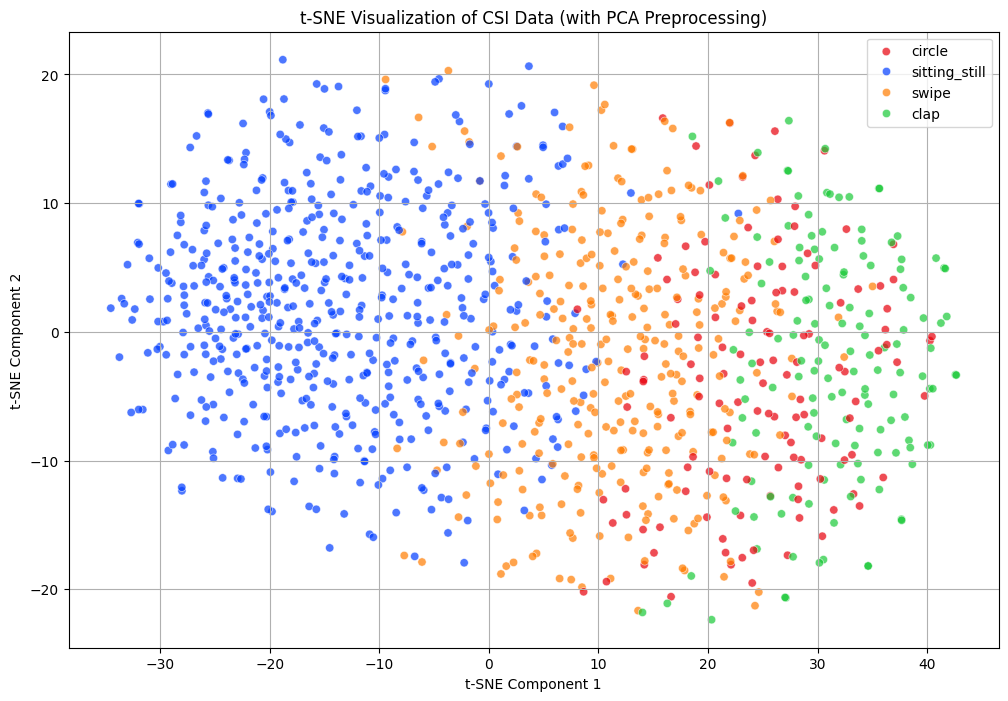

Explained Variance by PCA: 0.34


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten the CSI data for PCA
flattened_data = cnn_input_data.reshape(cnn_input_data.shape[0], -1)

# Apply PCA for dimensionality reduction before t-SNE
pca = PCA(n_components=50, random_state=42)  # Reduce to 50 dimensions
pca_data = pca.fit_transform(flattened_data)
tsne = TSNE(
        n_components=2,
        perplexity=25,
        n_iter=5000,
        n_iter_without_progress=300,
        random_state=3,
        n_jobs=-1,
    )
# Apply t-SNE to the PCA-transformed data
#tsne = TSNE(n_components=2, perplexity=25, n_iter=5000, random_state=42)
tsne_results = tsne.fit_transform(pca_data)

# Extract labels
class_labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
palette = sns.color_palette("bright", len(label_mapping))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=class_labels,
    palette=palette,
    legend="full",
    alpha=0.7
)

# Add title and labels
plt.title("t-SNE Visualization of CSI Data (with PCA Preprocessing)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(loc="best", labels=label_mapping.keys())
plt.grid()
plt.show()

# Optional: Print explained variance ratio from PCA
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance by PCA: {explained_variance:.2f}")


#### Summarization of Above chart

- ABove chart is visualizing different four gesture labels after reducing the dimension of the CSI Amplitude Data.
- Four different labels are creating clusters in which circle cluster is overlapping clap cluster.
- Need more separation for creating boundaries between different Labels.

#### 2.2.2 Below changed Hyperparameters of TSne Visulisation chart
- n_iter = 5000
- rotating the data dimension

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


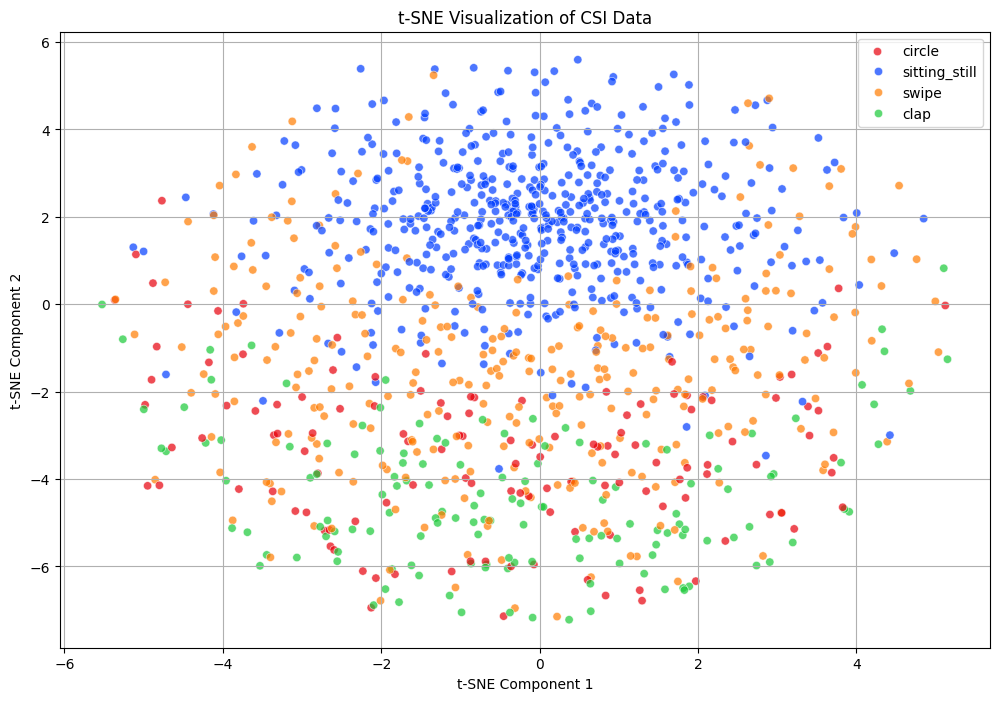

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten the CSI data for t-SNE
flattened_data = cnn_input_data.reshape(cnn_input_data.shape[0], -1)

# Apply t-SNE
tsne = TSNE(
        n_components=2,
        perplexity=25,
        n_iter=5000,
        n_iter_without_progress=300,
        random_state=3,
        n_jobs=-1,
    )
#tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(flattened_data)

# Extract labels
class_labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
palette = sns.color_palette("bright", len(label_mapping))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=class_labels,
    palette=palette,
    legend="full",
    alpha=0.7
)

# Add title and labels
plt.title("t-SNE Visualization of CSI Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(loc="best", labels=label_mapping.keys())
plt.grid()
plt.show()


#### Above Chart Summarization
- Not improved the border cluster compare to last visualisation.

#### 2.2.3 Below changed Hyperparameters of TSne Visulisation chart
- n_components=2, perplexity=30, n_iter=3000, random_state=42

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


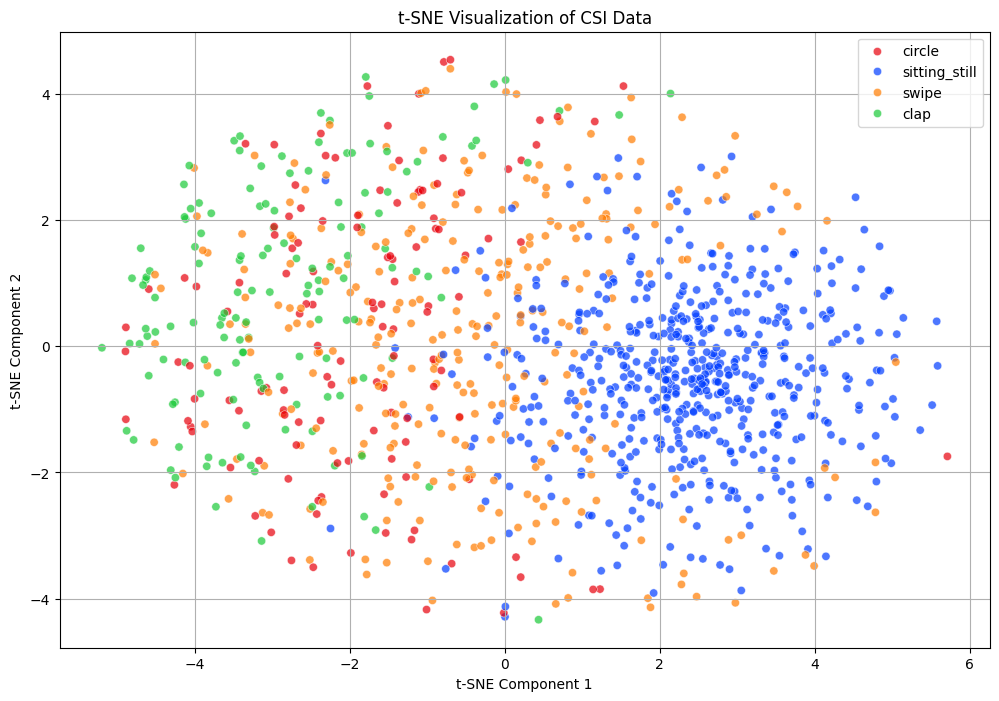

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten the CSI data for t-SNE
flattened_data = cnn_input_data.reshape(cnn_input_data.shape[0], -1)

# Apply t-SNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(flattened_data)

# Extract labels
class_labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
palette = sns.color_palette("bright", len(label_mapping))
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=class_labels,
    palette=palette,
    legend="full",
    alpha=0.7
)

# Add title and labels
plt.title("t-SNE Visualization of CSI Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(loc="best", labels=label_mapping.keys())
plt.grid()
plt.show()


## 2.3 Model Preparation , Training and Evaluation.

### 2.3.1 Data Preparation
#### Shuffle Dataset:

#### **Data Preparation**
1. **Shuffle Dataset**:
   - Shuffle the `cnn_input_data` and `labels` using `sklearn.utils.shuffle` to randomize the order of samples.

2. **Train-Test Split**:
   - Split the dataset into training and testing sets using an 80-20 ratio with `train_test_split`.

3. **Compute Class Weights**:
   - Calculate class weights using `compute_class_weight` to handle potential class imbalances.


In [ ]:
from sklearn.utils import shuffle

# Shuffle the data and labels
cnn_input_data, labels = shuffle(cnn_input_data, labels, random_state=42)

# Verify the shuffled data
print("Shuffled CNN Input Data Shape:", cnn_input_data.shape)
print("Shuffled Labels Shape:", labels.shape)

# Check the first sample and its label after shuffling
sample_index = 0  # You can change this to inspect other samples
print(f"Sample {sample_index} Shape: {cnn_input_data[sample_index].shape}")
print(f"Sample {sample_index} Label (One-hot): {labels[sample_index]}")


Shuffled CNN Input Data Shape: (1128, 58, 300, 1)
Shuffled Labels Shape: (1128, 4)
Sample 0 Shape: (58, 300, 1)
Sample 0 Label (One-hot): [1. 0. 0. 0.]


### Summary of Steps in the Code




#### **Model Design**
4. **Build Improved CNN Model**:
   - **Convolutional Layers**:
     - Add three convolutional layers, each followed by batch normalization, ReLU activation, and max pooling.
   - **Global Pooling and Dense Layers**:
     - Use `GlobalAveragePooling2D` to reduce dimensionality, followed by a dense layer with `ReLU` activation and L2 regularization.
     - Add a final dense layer with a softmax activation for multi-class classification.
   - **Compile Model**:
     - Use the Adam optimizer with a learning rate of 0.001, `categorical_crossentropy` loss, and `accuracy` as the evaluation metric.

---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

In [ ]:
# Function to build the improved CNN model
def build_improved_cnn(input_shape=(58, 300, 1), num_classes=4):
    model = Sequential()

    # Convolutional layers with Batch Normalization
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling and Dense layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cnn_input_data, labels, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights_dict = dict(enumerate(class_weights))

Training Data Shape: (902, 58, 300, 1)
Testing Data Shape: (226, 58, 300, 1)




#### **Model Training**
5. **Define Callbacks**:
   - **Learning Rate Reduction**:
     - Use `ReduceLROnPlateau` to reduce the learning rate by a factor of 0.5 if the validation loss plateaus for 3 epochs.
   - **Early Stopping**:
     - Stop training early if the validation loss does not improve for 5 epochs and restore the best model weights.

6. **Train the Model**:
   - Train the CNN model on the training data for up to 50 epochs with a batch size of 32.
   - Use the `class_weight` parameter to balance class distributions.
   - Monitor validation loss during training.

---

#### **Performance Analysis**
7. **Plot Training Progress**:
   - Plot the training and validation accuracy over epochs.
   - Plot the training and validation loss over epochs.

8. **Evaluate Model**:
   - Evaluate the trained model on the test data to compute test loss and accuracy.

---

#### **Predictions**
9. **Make Predictions**:
   - Predict the class probabilities for the test set using `cnn_model.predict`.
   - Convert predicted probabilities to class labels using `argmax`.

10. **Compare Predictions with Actual Labels**:
    - Print the predicted and actual class labels for the first 5 samples in the test set.


C:\Users\venka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 58, 300, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 300, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 150, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 150, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 150, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 37, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,620 (498.52 KB)

 Trainable params: 127,172 (496.77 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6001 - loss: 1.1779 - val_accuracy: 0.5487 - val_loss: 1.4209 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8363 - loss: 0.6542 - val_accuracy: 0.5487 - val_loss: 1.3006 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.8895 - loss: 0.5413 - val_accuracy: 0.5487 - val_loss: 1.2655 - learning_rate: 0.0010
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9280 - loss: 0.4220 - val_accuracy: 0.5487 - val_loss: 1.2952 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9264 - loss: 0.4349 - val_accuracy: 0.5487 - val_loss: 1.7573 - learning_rate: 0.0010
Epoch 6/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9595 - loss: 0.3336
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9575 - loss: 0.3391 - v

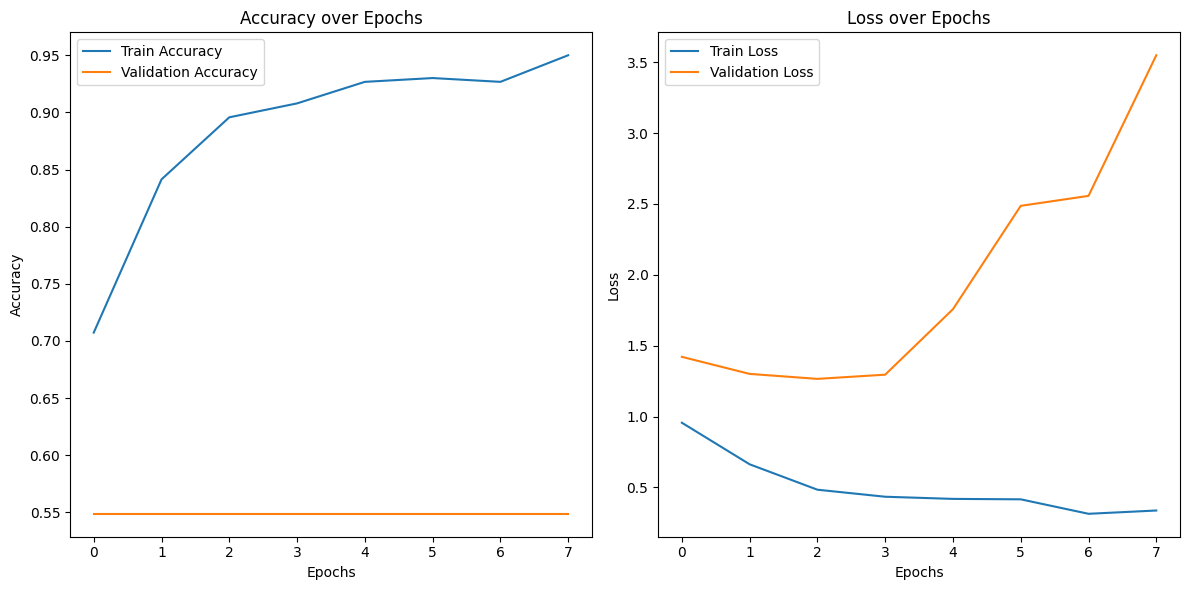

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5806 - loss: 1.2170
Test Accuracy: 54.87%
Test Loss: 1.2655
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sample 1: Predicted: 0, Actual: 2
Sample 2: Predicted: 0, Actual: 0
Sample 3: Predicted: 0, Actual: 0
Sample 4: Predicted: 0, Actual: 0
Sample 5: Predicted: 0, Actual: 1


In [ ]:
# Build the model
cnn_model = build_improved_cnn(input_shape=(58, 300, 1), num_classes=4)
cnn_model.summary()

# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=50,             # Adjust epochs based on convergence
    batch_size=32,         # Batch size
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,  # Handle class imbalance
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Example predictions
predictions = cnn_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Print example results
for i in range(5):
    print(f"Sample {i + 1}: Predicted: {predicted_classes[i]}, Actual: {actual_classes[i]}")

### **Summary of Results**
- **Model Performance**: Training accuracy reached 95.95%, but validation accuracy stayed low at 54.87%, indicating poor generalization.
- **Test Results**: Test accuracy was 54.87%, with a test loss of 1.2655, which is unsatisfactory.
- **Predictions**: The model's predictions were incorrect, often mismatching the actual labels.

### **Conclusion**
The model's performance is not good enough, suggesting issues with overfitting or underfitting. Further exploration of other methods is needed.

### **Next Steps**
- Experiment with advanced architectures and more data preprocessing.




---



#  2.4 Exploring new data visualisation and data reduction techniques with more preprocessing steps.

---



### **Summary of Steps for Data Preprocessing and Preparation for visualisation technique**

1. **File Paths Initialization**:  
   A dictionary (`file_paths`) is created to store the file paths of raw CSI data for different activities (e.g., circle, sitting_still, swipe, clap).

2. **Data Processing Loop**:  
   - **Iterate through each activity label**: Each activity (e.g., "circle", "sitting_still") is processed using its respective file path.
   - **Load and Clean Data**: A custom function (`load_and_clean_data`) is used to load and clean the raw data.
   
3. **Preprocessing**:
   - **Amplitude Preprocessing**: Extract and preprocess the amplitude data.
   - **Phase Preprocessing**: Extract and preprocess the phase data.
   
4. **Normalization**:
   - **Normalize Amplitude**: Apply normalization to the amplitude data.
   - **Normalize Phase**: Unwrap and normalize the phase data.

5. **CSI Ratio Computation (Optional)**:  
   - A CSI ratio is calculated from the amplitude data using the function `compute_csi_ratio`, although this step is optional.

6. **Data Combination**:  
   - **Combine Amplitude and Phase**: The normalized amplitude and phase data are combined into a single dataset using `combine_amplitude_phase`.

7. **Reshape for CNN**:  
   - **Reshaping**: The combined data is reshaped to a format suitable for input to a CNN using `reshape_for_cnn`.

8. **Data and Label Aggregation**:  
   - **Appending Data**: The reshaped data for each activity is appended to the `all_data` list.
   - **Creating Labels**: Labels are generated for each activity using `label_mapping` and are appended to the `all_labels` list.

9. **Concatenate Data and Labels**:  
   - All data from different activities is concatenated into one large array (`cnn_input_data`).
   - The corresponding labels are also concatenated into `labels`.

10. **One-Hot Encoding**:  
    - Labels are converted to categorical format (one-hot encoding) using `to_categorical`.

11. **Shuffling**:  
    - The data and labels are shuffled using `shuffle` from `sklearn.utils` to ensure randomization of training data.

12. **Final Dataset Verification**:  
    - The final shape of `cnn_input_data` and `labels` is printed for verification.


In [ ]:
def load_and_clean_data(file_path):
    """
    Load and clean the CSI data from a CSV file.
    """
    raw_data = pd.read_csv(file_path)
    # Drop rows with missing 'htltf_amplitude' or 'htltf_phase'
    cleaned_data = raw_data.dropna(subset=['htltf_amplitude', 'htltf_phase'])
    # Ensure both columns are strings for processing
    cleaned_data['htltf_amplitude'] = cleaned_data['htltf_amplitude'].astype(str)
    cleaned_data['htltf_phase'] = cleaned_data['htltf_phase'].astype(str)
    cleaned_data.reset_index(drop=True, inplace=True)
    return cleaned_data


In [ ]:
def preprocess_amplitude(cleaned_data):
    """
    Preprocess cleaned CSI data to extract amplitude from 'htltf_amplitude' column.
    """
    amplitude_data = cleaned_data['htltf_amplitude']
    csi_amplitude = []

    for row in amplitude_data:
        try:
            amplitude_values = list(map(float, row.strip("[]").split(',')))
            csi_amplitude.append(amplitude_values)
        except Exception as e:
            print(f"Error processing row: {row}, Error: {e}")

    return np.array(csi_amplitude)


In [ ]:
def preprocess_phase(cleaned_data):
    """
    Preprocess cleaned CSI data to extract phase from 'htltf_phase' column.
    """
    phase_data = cleaned_data['htltf_phase']
    csi_phase = []

    for row in phase_data:
        try:
            phase_values = list(map(float, row.strip("[]").split(',')))
            csi_phase.append(phase_values)
        except Exception as e:
            print(f"Error processing row: {row}, Error: {e}")

    return np.array(csi_phase)


In [ ]:
def normalize_amplitude(csi_amplitude):
    """
    Normalize amplitude data to range [0, 1].
    """
    min_val = np.min(csi_amplitude)
    max_val = np.max(csi_amplitude)
    return (csi_amplitude - min_val) / (max_val - min_val)


In [ ]:
def unwrap_and_normalize_phase(csi_phase):
    """
    Unwrap and normalize phase data to range [0, 1].
    """
    # Phase unwrapping to remove discontinuities
    unwrapped_phase = np.unwrap(csi_phase, axis=1)
    # Normalize to [0, 1]
    min_val = np.min(unwrapped_phase)
    max_val = np.max(unwrapped_phase)
    normalized_phase = (unwrapped_phase - min_val) / (max_val - min_val)
    return normalized_phase


## COMPUTING CSI RATIO

In [ ]:
def compute_csi_ratio(csi_amplitude):
    """
    Compute CSI ratio for consecutive subcarriers.
    """
    return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]


### COMBINE AMPLITUDE AND PHASE

In [ ]:
def combine_amplitude_phase(amplitude, phase):
    """
    Combine amplitude and phase into a single feature matrix.
    """
    return np.stack([amplitude, phase], axis=-1)  # Shape: (samples, subcarriers, 2)


In [ ]:
def reshape_for_cnn(combined_data, num_subcarriers=58, chunk_size=300):
    """
    Reshape combined amplitude and phase data for CNN input.
    """
    num_samples = combined_data.shape[0] // chunk_size
    return combined_data[:num_samples * chunk_size].reshape(num_samples, num_subcarriers, chunk_size, 2)


In [ ]:
# File paths for the raw CSI data
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
file_paths = {
    "circle": r"/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/circle_v2_STILL_with_htltf_amplitude_phase_FINAL.csv",
    "sitting_still": r"/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/sitting_still_v2_with_htltf_amplitude_phase_FINAL.csv",
    "swipe": r"/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/swipe_v1_with_htltf_amplitude_phase_FINAL.csv",
    "clap": r"/content/drive/MyDrive/csi_data/FINAL_PROCESSED_FILES/clap_v1_with_htltf_amplitude_phase_FINAL.csv"
}
# Initialize lists to hold data and labels
all_data = []
all_labels = []

for label_name, file_path in file_paths.items():
    print(f"Processing file: {label_name}")

    # Load and clean the data
    cleaned_data = load_and_clean_data(file_path)

    # Preprocess amplitude and phase
    amplitude = preprocess_amplitude(cleaned_data)
    phase = preprocess_phase(cleaned_data)

    # Normalize data
    normalized_amplitude = normalize_amplitude(amplitude)
    normalized_phase = unwrap_and_normalize_phase(phase)

    # Compute CSI ratio (optional)
    csi_ratio = compute_csi_ratio(amplitude)

    # Combine amplitude and phase
    combined_data = combine_amplitude_phase(normalized_amplitude, normalized_phase)

    # Reshape for CNN
    reshaped_data = reshape_for_cnn(combined_data)

    # Append to main data list
    all_data.append(reshaped_data)

    # Create labels for the data
    num_samples = reshaped_data.shape[0]
    labels = np.full(num_samples, label_mapping[label_name])
    all_labels.append(labels)

# Combine all data and labels
cnn_input_data = np.concatenate(all_data, axis=0)
labels = np.concatenate(all_labels, axis=0)

# Convert labels to categorical format (one-hot encoding)
labels = to_categorical(labels, num_classes=len(label_mapping))

# Shuffle the data and labels
cnn_input_data, labels = shuffle(cnn_input_data, labels, random_state=42)

# Verify the final dataset
print("Final CNN Input Data Shape:", cnn_input_data.shape)
print("Final Labels Shape:", labels.shape)


Processing file: circle


<ipython-input-7-10406e01cd2e>:5: RuntimeWarning: divide by zero encountered in divide
  return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]
<ipython-input-7-10406e01cd2e>:5: RuntimeWarning: invalid value encountered in divide
  return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]


Processing file: sitting_still


<ipython-input-7-10406e01cd2e>:5: RuntimeWarning: divide by zero encountered in divide
  return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]
<ipython-input-7-10406e01cd2e>:5: RuntimeWarning: invalid value encountered in divide
  return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]


Processing file: swipe


<ipython-input-7-10406e01cd2e>:5: RuntimeWarning: divide by zero encountered in divide
  return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]
<ipython-input-7-10406e01cd2e>:5: RuntimeWarning: invalid value encountered in divide
  return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]


Processing file: clap


<ipython-input-7-10406e01cd2e>:5: RuntimeWarning: divide by zero encountered in divide
  return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]
<ipython-input-7-10406e01cd2e>:5: RuntimeWarning: invalid value encountered in divide
  return csi_amplitude[:, 1:] / csi_amplitude[:, :-1]


Final CNN Input Data Shape: (1128, 58, 300, 2)
Final Labels Shape: (1128, 4)


### 2.5.1 The code applies PCA to reduce the dimensionality of the CSI features to 2 components and visualizes the data with a scatter plot, coloring the points by their class labels.

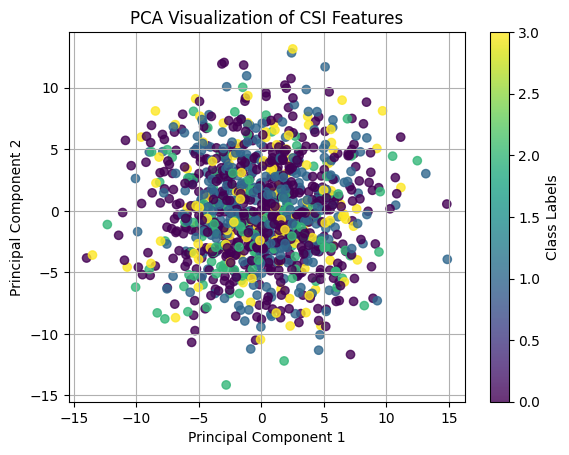

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(flattened_data)

# Plot PCA results
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=decoded_labels, cmap='viridis', alpha=0.8)
plt.title("PCA Visualization of CSI Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Class Labels')
plt.grid(True)
plt.show()


### 2.5.2 More methods for data visualisation
1. **Data Preparation**: The amplitude and phase data are flattened into 2D arrays to prepare them for dimensionality reduction.

2. **Normalization**: The data is normalized using MinMaxScaler to improve the performance of PCA and t-SNE.

3. **PCA Application**: PCA is applied to reduce the dimensionality of the amplitude and phase features to 2 components for visualization.

4. **t-SNE Application**: t-SNE is applied on the amplitude and phase features to visualize the data in a 2D space, using a perplexity of 30.

5. **Label Decoding**: The one-hot encoded labels are converted into integer format for visualization.

6. **Visualization**: The results of PCA and t-SNE are plotted in 2D scatter plots, with class labels represented by color for both amplitude and phase features.

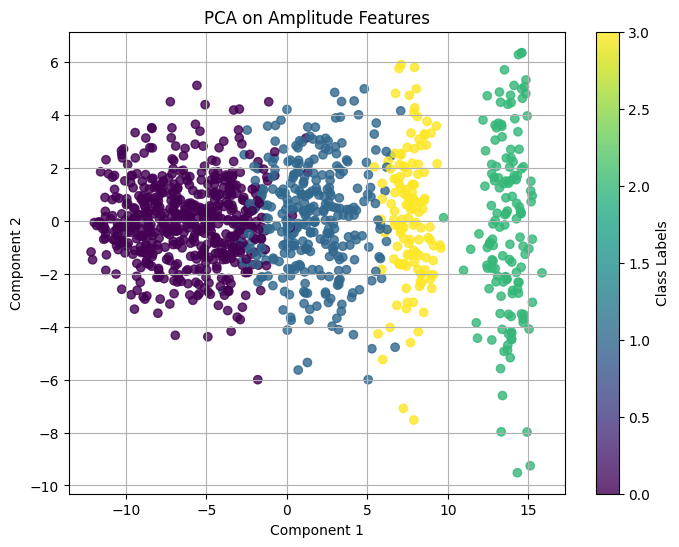

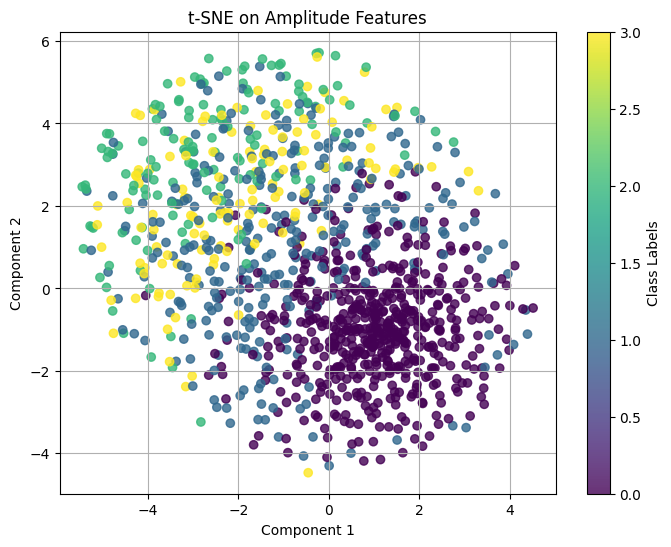

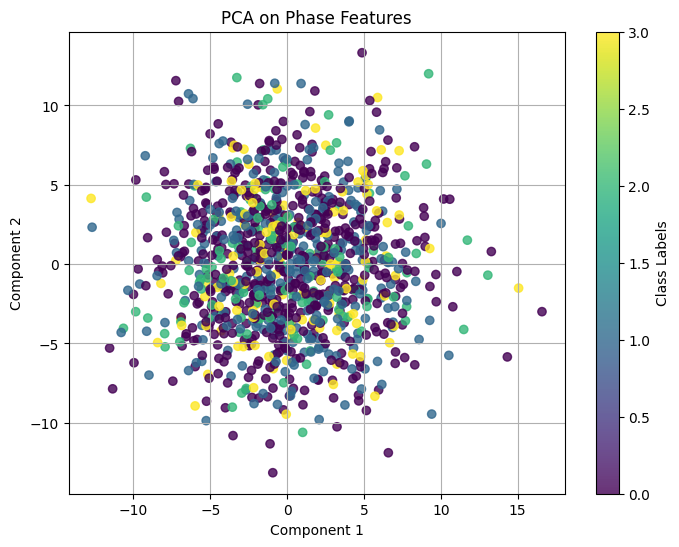

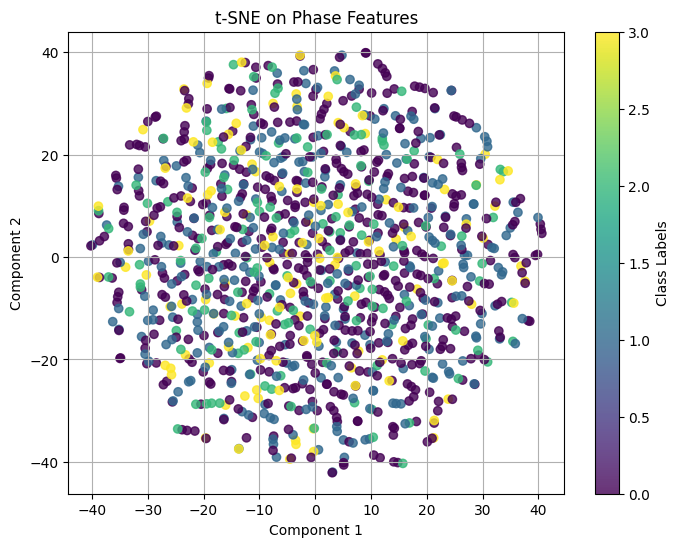

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Flatten amplitude and phase data for PCA and t-SNE
flattened_amplitude = cnn_input_data[..., 0].reshape(cnn_input_data.shape[0], -1)  # Amplitude
flattened_phase = cnn_input_data[..., 1].reshape(cnn_input_data.shape[0], -1)      # Phase

# Normalize the data (PCA and t-SNE work better with normalized data)
scaler = MinMaxScaler()
normalized_amplitude = scaler.fit_transform(flattened_amplitude)
normalized_phase = scaler.fit_transform(flattened_phase)

# Apply PCA
pca_amplitude = PCA(n_components=2).fit_transform(normalized_amplitude)
pca_phase = PCA(n_components=2).fit_transform(normalized_phase)

# Apply t-SNE
tsne_amplitude = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(normalized_amplitude)
tsne_phase = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(normalized_phase)

# Convert labels to integer format for visualization
decoded_labels = np.argmax(labels, axis=1)

# Plotting function
def plot_graphs(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.8)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Class Labels")
    plt.grid(True)
    plt.show()

# Visualize PCA and t-SNE results for amplitude
plot_graphs(pca_amplitude, decoded_labels, "PCA on Amplitude Features")
plot_graphs(tsne_amplitude, decoded_labels, "t-SNE on Amplitude Features")

# Visualize PCA and t-SNE results for phase
plot_graphs(pca_phase, decoded_labels, "PCA on Phase Features")
plot_graphs(tsne_phase, decoded_labels, "t-SNE on Phase Features")


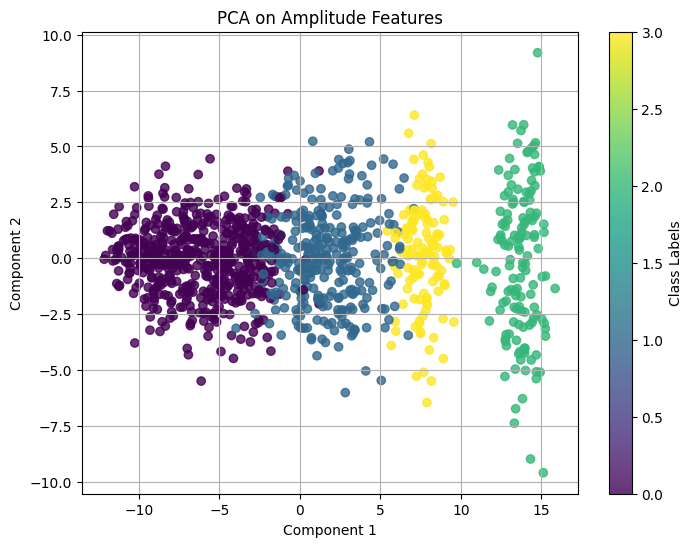

In [ ]:
plot_graphs(pca_amplitude, decoded_labels, "PCA on Amplitude Features")

1. **Data Standardization**: The amplitude and phase data are standardized using `StandardScaler` for better model performance.
2. **PCA Application**: PCA is applied to reduce the dimensions of the standardized data to 50 components.
3. **Feature Engineering**: Polynomial features (degree 2, interaction only) are applied to the reduced data for enhanced features, with a fallback to skip if memory usage is too high.
4. **Combining Features**: The enhanced amplitude and phase features are combined into a single feature set.

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

# Standardize amplitude and phase data
scaler = StandardScaler()
standardized_amplitude = scaler.fit_transform(flattened_amplitude)
standardized_phase = scaler.fit_transform(flattened_phase)

# Apply PCA to reduce dimensions before PolynomialFeatures
pca = PCA(n_components=50)
reduced_amplitude = pca.fit_transform(standardized_amplitude)
reduced_phase = pca.fit_transform(standardized_phase)

# Feature engineering with reduced data
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
try:
    enhanced_amplitude = poly.fit_transform(reduced_amplitude)
    enhanced_phase = poly.fit_transform(reduced_phase)
except MemoryError:
    print("MemoryError: Skipping PolynomialFeatures due to high memory usage.")
    enhanced_amplitude = reduced_amplitude
    enhanced_phase = reduced_phase

# Combine enhanced amplitude and phase
combined_features = np.hstack([enhanced_amplitude, enhanced_phase])


### 2.5.2 Visulaisation methods and charts
1. **PCA on Enhanced Amplitude**: Principal Component Analysis (PCA) is applied to reduce the dimensionality of the enhanced amplitude features to 2D for easier visualization.
2. **t-SNE on Enhanced Amplitude**: t-SNE (t-distributed Stochastic Neighbor Embedding) is applied to further reduce the dimensionality and capture the local structure of the data.
3. **UMAP on Enhanced Amplitude**: UMAP (Uniform Manifold Approximation and Projection) is used for dimensionality reduction, aiming to preserve both local and global data structure in 2D space.
4. **Plotting**: The results of PCA, t-SNE, and UMAP are plotted with labels, showing how the enhanced amplitude features are distributed across two components. The plots use color coding for class labels to provide insights into the clustering and separability of the data.


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


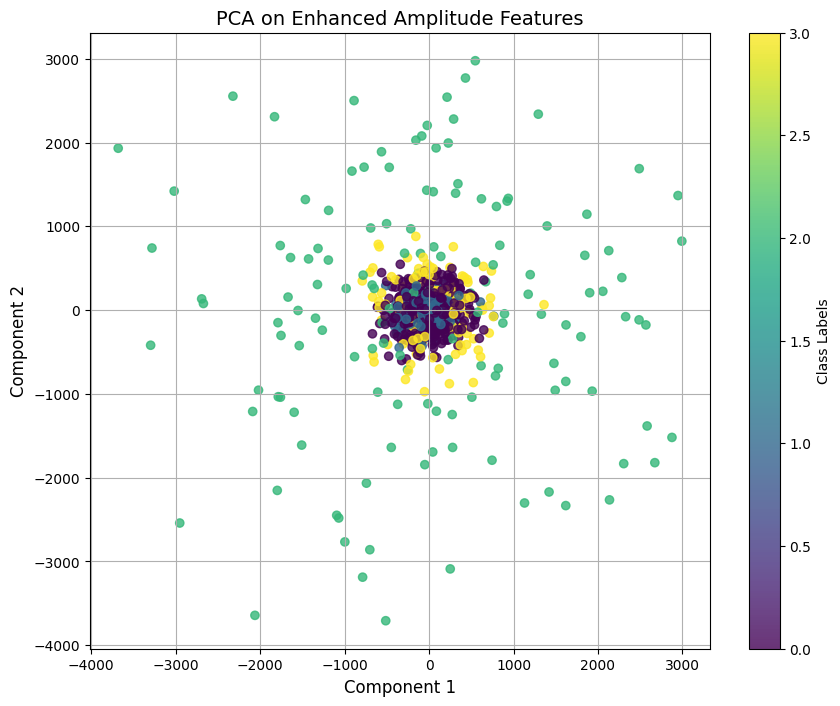

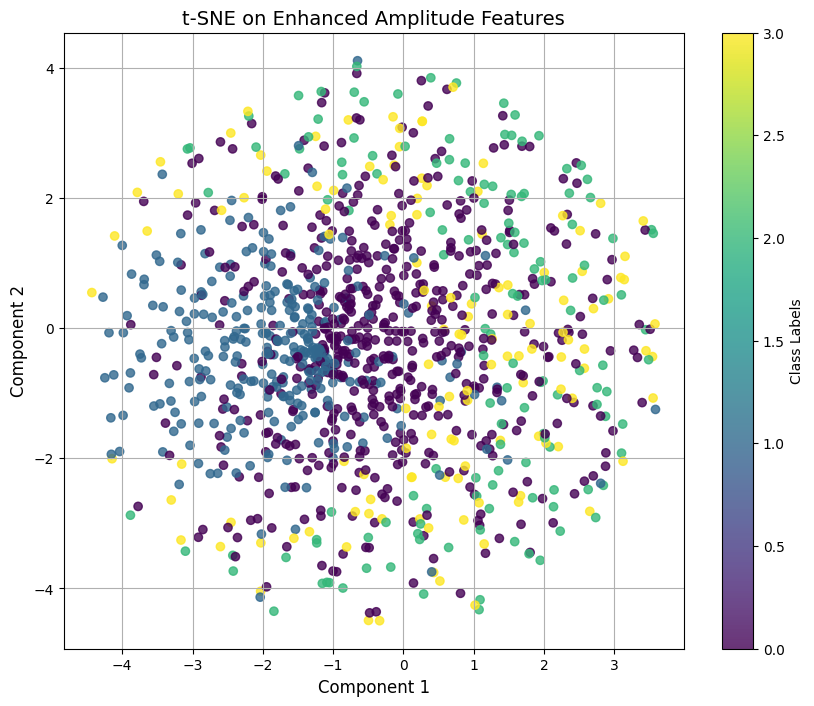

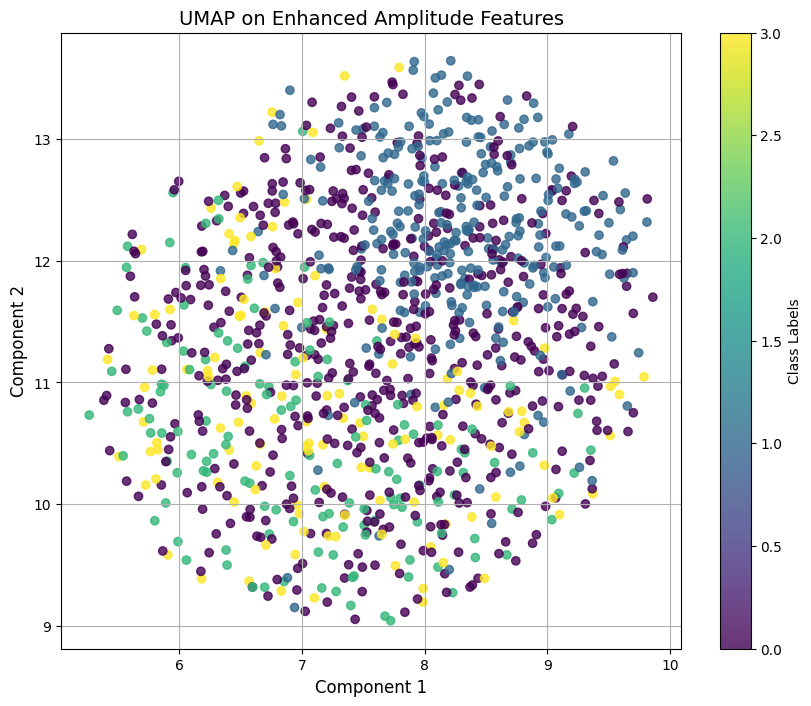

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP

# Dimensionality Reduction for Enhanced Amplitude
# Apply PCA to reduce enhanced amplitude to 2D
pca_enhanced_amplitude = PCA(n_components=2).fit_transform(enhanced_amplitude)

# Apply t-SNE for enhanced amplitude
tsne_enhanced_amplitude = TSNE(
    n_components=2, perplexity=30, random_state=42
).fit_transform(enhanced_amplitude)

# Apply UMAP for enhanced amplitude
umap_enhanced_amplitude = UMAP(
    n_components=2, n_neighbors=30, min_dist=0.1, random_state=42
).fit_transform(enhanced_amplitude)

# Plotting Function for Enhanced Amplitude
def plot_amplitude(data, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.8)
    plt.title(title, fontsize=14)
    plt.xlabel("Component 1", fontsize=12)
    plt.ylabel("Component 2", fontsize=12)
    plt.colorbar(scatter, label="Class Labels")
    plt.grid(True)
    plt.show()

# Convert labels to integer format for visualization
decoded_labels = np.argmax(labels, axis=1)

# Visualize Enhanced Amplitude with PCA
plot_amplitude(pca_enhanced_amplitude, decoded_labels, "PCA on Enhanced Amplitude Features")

# Visualize Enhanced Amplitude with t-SNE
plot_amplitude(tsne_enhanced_amplitude, decoded_labels, "t-SNE on Enhanced Amplitude Features")

# Visualize Enhanced Amplitude with UMAP
plot_amplitude(umap_enhanced_amplitude, decoded_labels, "UMAP on Enhanced Amplitude Features")


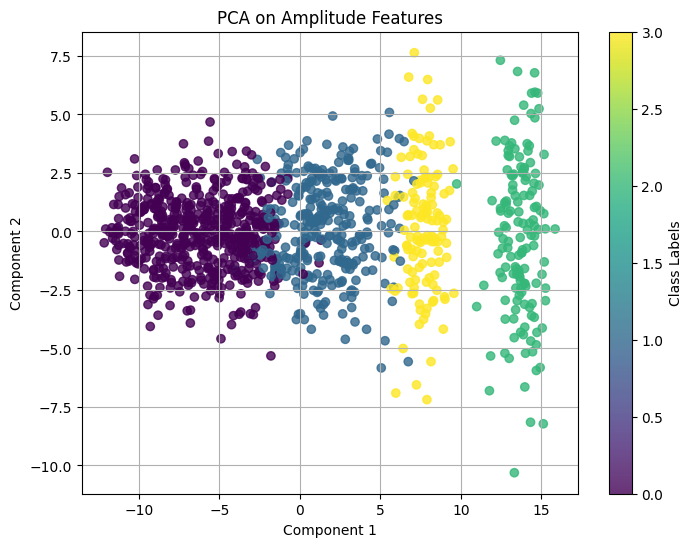

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Flatten amplitude and phase data for PCA and t-SNE
flattened_amplitude = cnn_input_data[..., 0].reshape(cnn_input_data.shape[0], -1)  # Amplitude

# Normalize the data (PCA and t-SNE work better with normalized data)
scaler = MinMaxScaler()
normalized_amplitude = scaler.fit_transform(flattened_amplitude)

# Apply PCA
pca_amplitude = PCA(n_components=100).fit_transform(normalized_amplitude)


# Convert labels to integer format for visualization
decoded_labels = np.argmax(labels, axis=1)

# Plotting function
def plot_graphs(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.8)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Class Labels")
    plt.grid(True)
    plt.show()

# Visualize PCA and t-SNE results for amplitude
plot_graphs(pca_amplitude, decoded_labels, "PCA on Amplitude Features")



### 2.5.3 Tuning hyperparameters with enhanced aplitude and csi ratio with different visualisation methods.
1. **Flatten Amplitude Data**: The amplitude data is flattened to prepare for dimensionality reduction.
2. **Normalization with RobustScaler**: The data is normalized using RobustScaler to reduce the impact of outliers.
3. **PCA for Intermediate Dimensionality Reduction**: PCA with 10 components is applied to reduce the data's dimensionality before t-SNE.
4. **t-SNE for 2D Visualization**: t-SNE is used to further reduce the dimensionality to 2D, aiming for better separation and visualization of the data.
5. **Visualization**: A scatter plot is created using the 2D t-SNE results, with colors representing different class labels.

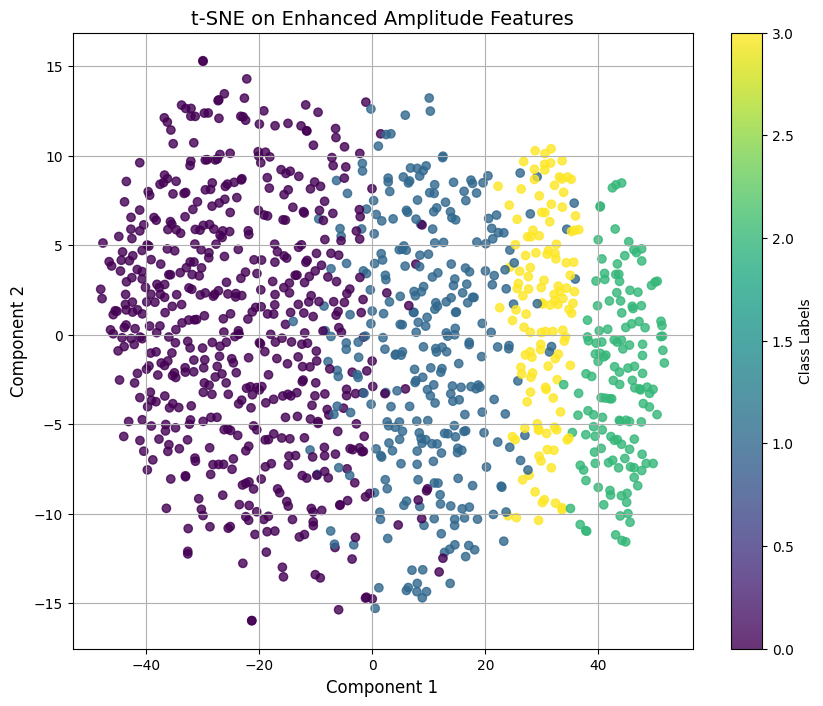

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import RobustScaler



# Flatten amplitude data
flattened_amplitude = cnn_input_data[..., 0].reshape(cnn_input_data.shape[0], -1)  # Amplitude
# Robust normalization for amplitude features
scaler = RobustScaler()
normalized_amplitude = scaler.fit_transform(flattened_amplitude)
# Standardize the data
#scaler = StandardScaler()
#standardized_amplitude = scaler.fit_transform(flattened_amplitude)

# Add polynomial features to amplify non-linear relationships
#poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
#enhanced_amplitude = poly.fit_transform(standardized_amplitude)

# Apply PCA with more components
pca_intermediate = PCA(n_components=10).fit_transform(standardized_amplitude)

# Apply t-SNE for improved separation in 2D space
tsne_amplitude = TSNE(n_components=2, perplexity=40, learning_rate=200, random_state=42).fit_transform(pca_intermediate)

# Convert labels to integer format for visualization
decoded_labels = np.argmax(labels, axis=1)

# Plotting function
def plot_graphs(data, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.8)
    plt.title(title, fontsize=14)
    plt.xlabel("Component 1", fontsize=12)
    plt.ylabel("Component 2", fontsize=12)
    plt.colorbar(scatter, label="Class Labels")
    plt.grid(True)
    plt.show()

# Visualize t-SNE results for amplitude with enhanced features
plot_graphs(tsne_amplitude, decoded_labels, "t-SNE on Enhanced Amplitude Features")


### PCA with enhanced amplitude.

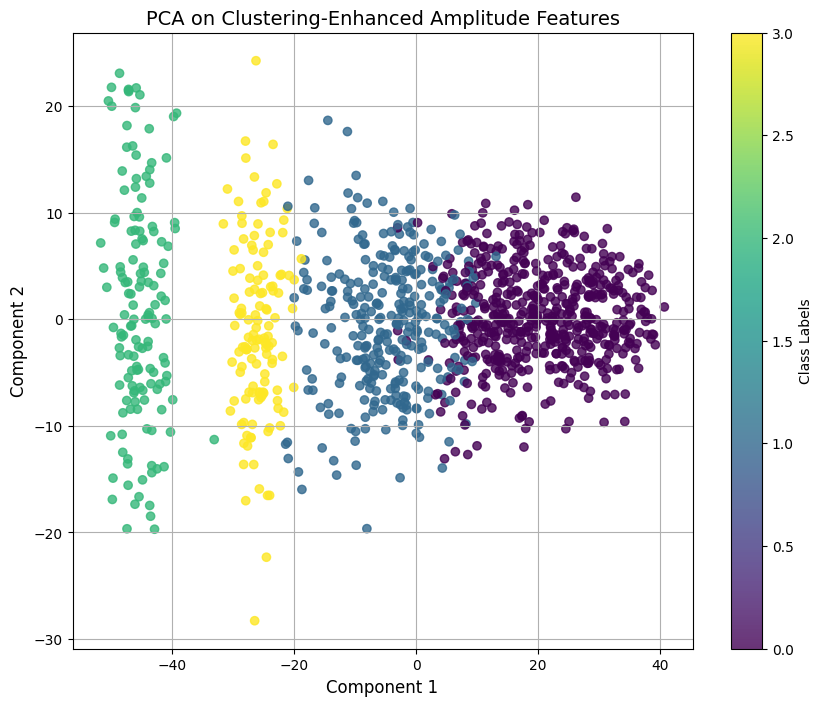

In [ ]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_amplitude)

# Add cluster labels as a feature
enhanced_amplitude = np.hstack([normalized_amplitude, cluster_labels.reshape(-1, 1)])

# Apply PCA or t-SNE on enhanced features
pca_amplitude = PCA(n_components=2).fit_transform(enhanced_amplitude)
plot_graphs(pca_amplitude, decoded_labels, "PCA on Clustering-Enhanced Amplitude Features")


### LDA with Enhances Amplitude features.

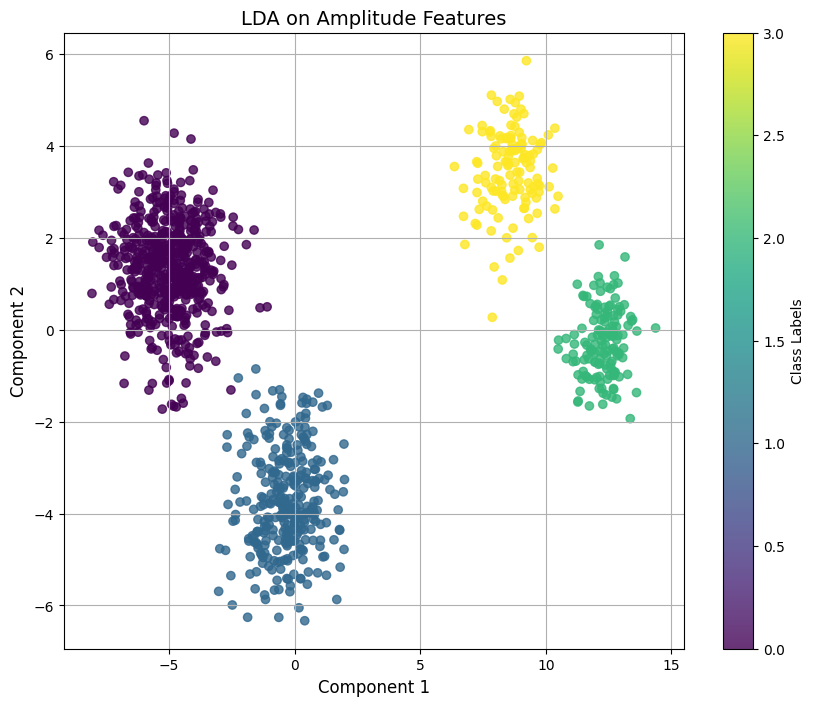

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA for dimensionality reduction
lda_amplitude = LDA(n_components=2).fit_transform(normalized_amplitude, decoded_labels)
plot_graphs(lda_amplitude, decoded_labels, "LDA on Amplitude Features")


### 2.5.4 Visulising LDA amplitude features
1. **Flatten Amplitude Data**: The amplitude data is reshaped into a 2D format.
2. **Normalize Data**: MinMaxScaler is used to normalize the amplitude features.
3. **Apply LDA**: Linear Discriminant Analysis (LDA) is applied for dimensionality reduction, projecting the data into 2D based on class labels.
4. **Visualization**: A scatter plot is generated to visualize the 2D LDA-transformed data, with points colored according to their class labels.

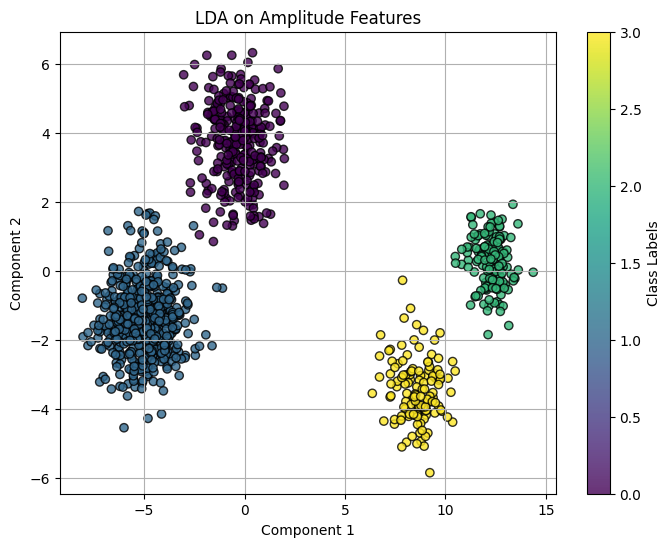

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
# Convert labels to integer format for visualization
decoded_labels = np.argmax(labels, axis=1)
# Flatten amplitude data
flattened_amplitude = cnn_input_data[..., 0].reshape(cnn_input_data.shape[0], -1)

# Normalize amplitude features
scaler = MinMaxScaler()
normalized_amplitude = scaler.fit_transform(flattened_amplitude)

# Apply LDA for dimensionality reduction
lda = LDA(n_components=2)
lda_amplitude = lda.fit_transform(normalized_amplitude, decoded_labels)


# Plotting function
def plot_graphs(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.8, edgecolors='k')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Class Labels")
    plt.grid(True)
    plt.show()

# Visualize results
plot_graphs(lda_amplitude, decoded_labels, "LDA on Amplitude Features")


## **2.5.5** Experimenting with LDA and kmeans feature Extraction.

1. **Flatten Amplitude Data**: Amplitude features are reshaped into a 2D format.
2. **Normalize Data**: MinMaxScaler normalizes the amplitude features to a common scale.
3. **Apply LDA**: Linear Discriminant Analysis (LDA) reduces dimensionality to 2 components, while preserving class separability.
4. **KMeans Clustering**: KMeans clustering with 4 clusters is applied on the LDA-reduced features.
5. **Combine Features**: The LDA features and KMeans cluster labels are combined into a new feature set.
6. **PCA on Combined Features**: PCA is applied to the combined LDA and KMeans features for visualization.
7. **Visualization**:
   - LDA results are visualized using scatter plots, showing class separations in 2D.
   - PCA on the combined features (LDA + KMeans) is visualized to assess how clustering influences the data representation.

**Comparison**:
- **LDA** focuses on class separability, while **KMeans** adds unsupervised clustering based on the LDA-reduced data, and **PCA** visualizes how these combined features relate in 2D space.

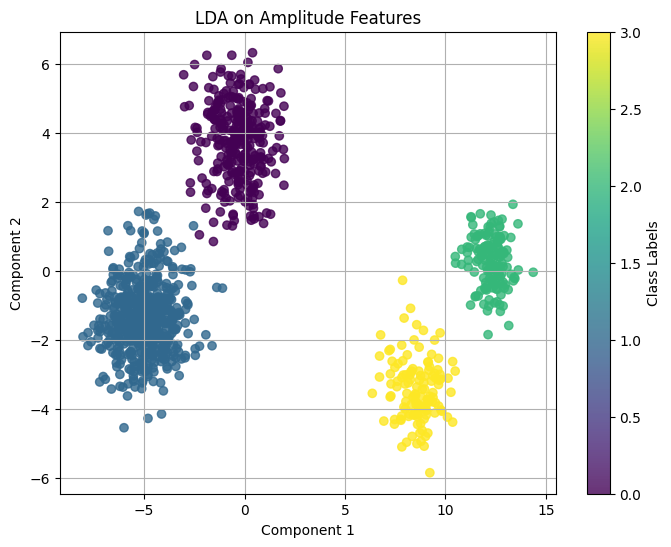

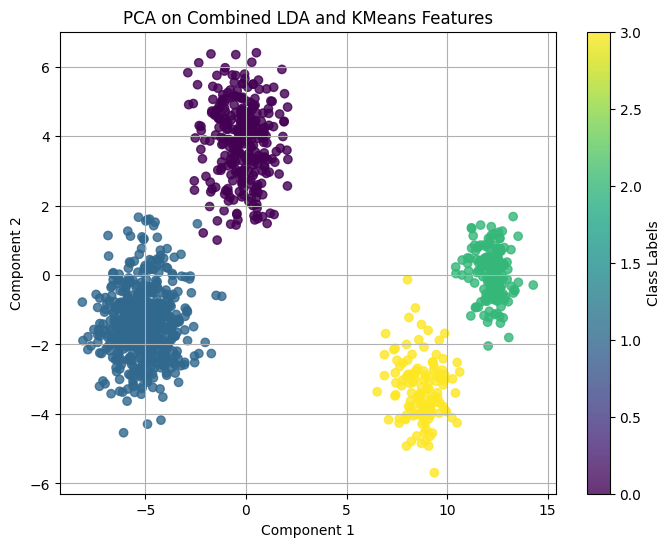

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Flatten amplitude data
flattened_amplitude = cnn_input_data[..., 0].reshape(cnn_input_data.shape[0], -1)

# Normalize amplitude features
scaler = MinMaxScaler()
normalized_amplitude = scaler.fit_transform(flattened_amplitude)

# Apply LDA for dimensionality reduction
lda = LDA(n_components=2)
lda_amplitude = lda.fit_transform(normalized_amplitude, decoded_labels)

# Apply KMeans clustering on LDA-reduced features
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(lda_amplitude)

# Combine LDA features and KMeans cluster labels
combined_features = np.hstack([lda_amplitude, cluster_labels.reshape(-1, 1)])

# Apply PCA on the combined features for visualization
pca_combined = PCA(n_components=2).fit_transform(combined_features)

# Plotting function
def plot_graphs(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.8)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Class Labels")
    plt.grid(True)
    plt.show()

# Visualize results
plot_graphs(lda_amplitude, decoded_labels, "LDA on Amplitude Features")
plot_graphs(pca_combined, decoded_labels, "PCA on Combined LDA and KMeans Features")


### **Conclusion of Visualization**

- LDA, as a dimensionality reduction technique, effectively creates clusters and separates each label with clearer boundaries.

- After enhancing the Amplitude features, PCA with 2 components further strengthens the separation between labels, increasing the cluster distances for better distinction.

- Both methods, LDA and PCA, provide enhanced and clear visualizations, demonstrating effective label separation, which is beneficial for classification tasks.

- While LDA, a supervised method, focuses on class separability, PCA, an unsupervised technique, emphasizes the structure of the data. This indicates the need for different models to be applied for training and evaluation.